In [ ]:
%pip install selenium
%pip install beautifulsoup4
%pip install requests
%pip install xgboost

In [83]:
%load_ext autoreload
%autoreload 2

In [84]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import GridSearchCV

## Scraping data

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Base URL
base_url = 'https://www.batdongsanonline.vn/mua-ban-dat-tinh-binh-duong/'

# List to store all the scraped data
all_listings = []

# Function to scrape data from a single page
def scrape_page(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    
    # Find all listing items
    items = soup.find_all('li', class_='chinh')
    
    listings = []
    
    for item in items:
        # Extract the title and link
        title_tag = item.find('a', title=True)
        title = title_tag['title'] if title_tag else None
        link = title_tag['href'] if title_tag else None
    
        # Extract the image URL
        image_tag = item.find('img', class_='lazy')
        image_url = image_tag['src'] if image_tag else None
    
        # Extract the area and price from the p tag
        p_tag = item.find('p')
        if p_tag:
            spans = p_tag.find_all('span')
            area = None
            price = None
            for span in spans:
                if 'Diện tích:' in span.text:
                    area = span.find('i').text.strip() if span.find('i') else None
                elif 'Giá:' in span.text:
                    price = span.find('i').text.strip() if span.find('i') else None
    
        # Extract the address
        address_tag = item.find('div', class_='address')
        address = address_tag.text.strip() if address_tag else None
    
        # Extract the description
        description_tag = item.find('div', class_='des_spec_bds')
        description = description_tag.text.strip() if description_tag else None
    
        # Extract the date
        date_tag = item.find('span', style=lambda x: x and 'color:' in x)
        date = date_tag.text.strip() if date_tag else None
    
        # Store the extracted data in a dictionary
        listing_data = {
            'Title': title,
            'Link': link,
            'Image URL': image_url,
            'Area': area,
            'Price': price,
            'Address': address,
            'Description': description,
            'Date': date
        }
    
        # Append the dictionary to the list of listings
        listings.append(listing_data)
    
    return listings

# Start URL
current_url = base_url

# Loop through pages
for _ in range(60):  # Limit to 100 pages or as needed
    print(f"Scraping: {current_url}")
    
    # Scrape the current page
    page_listings = scrape_page(current_url)
    all_listings.extend(page_listings)
    
    # Find the "next" page link
    r = requests.get(current_url)
    soup = BeautifulSoup(r.text, 'lxml')
    next_page_link = soup.find('a', rel='next')
    
    if next_page_link:
        current_url = next_page_link.get('href')
    else:
        break  # No more pages

# Create a DataFrame from the list of all listings
df = pd.DataFrame(all_listings)

# Print the DataFrame
df.shape

In [86]:
df.head()

,Title,Link,Image URL,Area,Price,Address,Description,Date
0,"Cần bán nền Tái Định Cư An Sơn, Thuận An Bình ...",https://www.batdongsanonline.vn/Can-ban-nen-Ta...,https://www.batdongsanonline.vn/image/catalog/...,100 m²,2.25 Tỷ,"Thuận An, Bình Dương","tổng diện tích: 100m2 full thổ cư, ngang 5mx20...",08/07/2024
1,"THUA CÁ ĐỘ ĐÁ BANH BÁN GẤP 1000M2 NGAY THỊ XÃ,...",https://www.batdongsanonline.vn/THUA-CA-DO-DA-...,https://www.batdongsanonline.vn/image/catalog/...,1000 m²,290 Triệu,"Bàu Bàng, Bình Dương",thua cá độ đá banh cần tiền trả nợ nên tôi cần...,2 giờ trước
2,TÔI CẦN SANG GẤP 540M2 ĐẤT NẰM NGAY TRUNG TÂM ...,https://www.batdongsanonline.vn/TOI-CAN-SANG-G...,https://www.batdongsanonline.vn/image/catalog/...,5400 m²,1.1 Tỷ,"Bến Cát, Bình Dương",ôi chính chủ tài sản cần dòng vốn để xoay sở c...,3 giờ trước
3,BÁN 420M2 ĐẤT NGAY KHU ĐỘ THỊ &CÔNG NGHIỆP DÂN...,https://www.batdongsanonline.vn/BAN-420M2-DAT-...,https://www.batdongsanonline.vn/image/catalog/...,420 m²,1.25 Tỷ,"Bến Cát, Bình Dương",- chính chủ cần bán 400m2 đất ngay khu đô thị ...,3 giờ trước
4,"CẦN BÁN GẤP 129M(6X20.8) ĐỐI DIỆN SIÊU THỊ, SÁ...",https://www.batdongsanonline.vn/CAN-BAN-GAP-12...,https://www.batdongsanonline.vn/image/catalog/...,129 m²,3.5 Tỷ,"Thuận An, Bình Dương","dự định xây nhà ở, do nay cần tiền để xoay sở ...",4 giờ trước


In [87]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to scrape additional information from detailed page
def scrape_details(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')

    # Extract the title
    title_tag = soup.find('h1', class_='title_D')
    title = title_tag.text.strip() if title_tag else None

    # Extract the detailed information
    details = {
        'Title': title,
        'Chiều ngang': None,
        'Chiều dài': None,
        'Đường trước đất': None,
        'Pháp lý': None,
        'Tình trạng': None,
        'Đường': None,
        'Diện tích thổ cư': None,
        'Đặc điểm nổi bật': None
    }

    # Find the list of details
    detail_list = soup.find('ul', class_='listTienich')
    if detail_list:
        items = detail_list.find_all('li')
        for item in items:
            span_tag = item.find('span')
            div_tag = item.find('div', class_='text-right fr')
            
            # Safely extract text and value
            text = span_tag.text.strip() if span_tag else None
            value = div_tag.text.strip() if div_tag else None

            # Check if text is not None before using it
            if text:
                if 'Chiều ngang' in text:
                    details['Chiều ngang'] = value
                elif 'Chiều dài' in text:
                    details['Chiều dài'] = value
                elif 'Đường trước đất' in text:
                    details['Đường trước đất'] = value
                elif 'Pháp lý' in text:
                    details['Pháp lý'] = value
                elif 'Tình trạng' in text:
                    details['Tình trạng'] = value
                elif 'Đường' in text:
                    details['Đường'] = value
                elif 'Diện tích thổ cư' in text:
                    details['Diện tích thổ cư'] = value
                elif 'Đặc điểm nổi bật' in text:
                    details['Đặc điểm nổi bật'] = value

    return details

# Example DataFrame structure
data = df[['Title', 'Link']]

# List to store additional details
additional_details = []

# Iterate through each link in the DataFrame
for index, row in data.iterrows():
    url = row['Link']
    details = scrape_details(url)
    additional_details.append(details)

# Convert additional details to DataFrame
details_df = pd.DataFrame(additional_details)

# Combine with the original DataFrame
# df_combined = pd.concat([data, details_df], axis=1)

# print(df_combined)
details_df.head()

,Title,Chiều ngang,Chiều dài,Đường trước đất,Pháp lý,Tình trạng,Đường,Diện tích thổ cư,Đặc điểm nổi bật
0,"Cần Bán Nền Tái Định Cư An Sơn, Thuận An Bình ...",5m,20m,7m,Sổ hồng sẵn,Đất trống,Bê tông,100m2,Mua chính chủ
1,"THUA CÁ ĐỘ ĐÁ BANH BÁN GẤP 1000M2 NGAY THỊ XÃ,...",None,None,None,Sổ hồng sẵn,None,None,None,None
2,TÔI CẦN SANG GẤP 540M2 ĐẤT NẰM NGAY TRUNG TÂM ...,18m,30m,16m,Sổ hồng sẵn,Đất trống,Bê tông,540m2,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻ
3,BÁN 420M2 ĐẤT NGAY KHU ĐỘ THỊ &CÔNG NGHIỆP DÂN...,14m,30m,12m,Sổ hồng sẵn,Đất trống,Nhựa,420m2,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất...
4,"CẦN BÁN GẤP 129M(6X20.8) ĐỐI DIỆN SIÊU THỊ, SÁ...",None,None,None,None,None,None,None,None


On the website, every property has its own direct link that lead to the page showcasing more detail, I continue scraping those direct urls for more information

In [94]:
detail = details_df.reset_index()
dfr = df.reset_index()

In [166]:
cp_data = dfr.merge(detail, on = 'index', how = 'inner')
cp_data = cp_data.drop(columns = ['Link', 'Image URL', 'Date', 'index', 'Title_y'])
cp_data = cp_data.rename(columns={'Title_x': 'Title'})

The title of the property change after going to the direct url thus I merge using index

In [167]:
cp_data.head()

,Title,Area,Price,Address,Description,Chiều ngang,Chiều dài,Đường trước đất,Pháp lý,Tình trạng,Đường,Diện tích thổ cư,Đặc điểm nổi bật
0,"Cần bán nền Tái Định Cư An Sơn, Thuận An Bình ...",100 m²,2.25 Tỷ,"Thuận An, Bình Dương","tổng diện tích: 100m2 full thổ cư, ngang 5mx20...",5m,20m,7m,Sổ hồng sẵn,Đất trống,Bê tông,100m2,Mua chính chủ
1,"THUA CÁ ĐỘ ĐÁ BANH BÁN GẤP 1000M2 NGAY THỊ XÃ,...",1000 m²,290 Triệu,"Bàu Bàng, Bình Dương",thua cá độ đá banh cần tiền trả nợ nên tôi cần...,None,None,None,Sổ hồng sẵn,None,None,None,None
2,TÔI CẦN SANG GẤP 540M2 ĐẤT NẰM NGAY TRUNG TÂM ...,5400 m²,1.1 Tỷ,"Bến Cát, Bình Dương",ôi chính chủ tài sản cần dòng vốn để xoay sở c...,18m,30m,16m,Sổ hồng sẵn,Đất trống,Bê tông,540m2,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻ
3,BÁN 420M2 ĐẤT NGAY KHU ĐỘ THỊ &CÔNG NGHIỆP DÂN...,420 m²,1.25 Tỷ,"Bến Cát, Bình Dương",- chính chủ cần bán 400m2 đất ngay khu đô thị ...,14m,30m,12m,Sổ hồng sẵn,Đất trống,Nhựa,420m2,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất...
4,"CẦN BÁN GẤP 129M(6X20.8) ĐỐI DIỆN SIÊU THỊ, SÁ...",129 m²,3.5 Tỷ,"Thuận An, Bình Dương","dự định xây nhà ở, do nay cần tiền để xoay sở ...",None,None,None,None,None,None,None,None


In [168]:
# Replace non-numeric characters and empty strings, and convert to float
cp_data[['Chiều ngang', 'Chiều dài', 'Đường trước đất']] = (
    cp_data[['Chiều ngang', 'Chiều dài', 'Đường trước đất']]
    .replace({'m': '', 'q': '', 'gànga': '', 'NE3': '',',': '.'}, regex=True)  # Remove non-numeric characters
    .apply(lambda x: x.str.strip())  # Strip any leading/trailing whitespace
    .replace('', np.nan)  # Replace empty strings with NaN
    .astype(float)  # Convert to float
)
# Remove "Bình Dương" from the 'location' column
cp_data['Address'] = cp_data['Address'].str.replace(', Bình Dương', '').str.strip()
# Function to extract numeric values
def extract_numeric(value):
    if isinstance(value, str):
        value = value.replace('m²', '').replace('m2', '').replace(',', '').strip()
    return pd.to_numeric(value, errors='coerce')
# Apply the conversion function to the DataFrame columns
cp_data['Area'] = cp_data['Area'].apply(extract_numeric)
cp_data['Diện tích thổ cư'] = cp_data['Diện tích thổ cư'].apply(extract_numeric)
cp_data['Area_r']= cp_data['Chiều dài']*cp_data['Chiều ngang']

Changing the dataset into the correcy format and ready for analysis

In [169]:
import pandas as pd
import numpy as np

# Function to convert price strings to numeric values
def convert_price(row):
    price_str = row['Price']
    area = row['Area_r']
    
    if pd.isnull(price_str):
        return np.nan

    # Remove any commas and whitespace
    price_str = price_str.replace(',', '').strip()

    # Dictionary to map units to their respective multipliers
    unit_multipliers = {
        'Tỷ': 1e9,            # Billion
        'Triệu': 1e6,         # Million
        'Triệu/m2': 1e6,      # Million per square meter
        'Thỏa thuận': np.nan  # Special case for agreements
    }
# Return NaN for 'Triệu/Tháng'
    if 'Triệu/Tháng' in price_str:
        return np.nan

    # Extract numeric value and unit
    for unit, multiplier in unit_multipliers.items():
        if unit in price_str:
            if unit == 'Triệu/Tháng':
                    return np.nan
            # Split numeric part and unit
            num_str = price_str.split(unit)[0].strip()
            try:
                # Convert numeric part to float
                num_value = float(num_str)
                if unit == 'Tỷ':
                    if num_value > 20 and num_value < 100:
                        return num_value * 1e7
                    elif num_value > 100 and num_value < 1000:
                        # User might have used "Tỷ" instead of "Triệu"
                        return num_value * 1e6
                    elif num_value >= 1000:
                        # Correct for values larger than 1,000 tỷ
                        return num_value * 1e6 
                    else:
                        return num_value * multiplier
                
                elif unit == 'Triệu':
                    if num_value <100:
                        return np.nan
                    else:
                        return num_value * multiplier

                # Handle special case for 'Triệu/m2' by multiplying with area
                if unit == 'Triệu/m2' and area is not None:
                    return num_value * multiplier * area
                
                return num_value * multiplier
            except ValueError:
                return np.nan

    # Handle any cases not covered by the unit multipliers
    try:
        # If no unit is found, assume the value is in millions
        return float(price_str) * 1e6
    except ValueError:
        return np.nan

# Apply conversion function and replace the 'price' column
cp_data['Price'] = cp_data.apply(convert_price, axis=1)
cp_data = cp_data[~((cp_data['Title'].isin(['Chủ Kẹt Tiền Cần Bán Nhanh Lô Đất 300m2 Tại KĐT Mới Bình Dương - T/Cư 100%,Ngay TT Hành Chính',
       'Chính chủ cần bán lô đất 150m2, 7.5x20, thổ cư, ngay chợ dân sinh',
       'Chỉ 15%  Sở Hữu Đất Mặt Tiền Trục Thương Mại 17m Tại Bàu Bàng',
       'Cắt lỗ lô đất dự án Nam An New City Bàu Bàng',
       'Cần bán gấp lô đất full thổ cư Bàu Bàng Bình Dương',
       'Cần bán lô đất mặt tiền đường 17m đối diện trường THCS tại Bàu Bàng 1ty550/100m2',
       'Chính Chủ bán lô đất trong khu công nghiệp Bàu Bàng, mt đường 17m.',
       'Chính chủ bán lô đất nam an bàu bàng giá 1ty550',
       'Cần tiền làm ăn , cần BÁN GẤP , ai quan tâm liên hẹ trực tiếp sđt 0379335142',
       'Dự án siêu rẻ ở Bình Dương cực hottt',
       'Ngân hàng dí lắm rồi nên cần bán gấp lô góc 2 MT 450m2 (18x25m), đối diện chợ, ngay KCN Việt Sing']))&(cp_data['Price'] >1e10))]

Description:

The website has several data entry issues with user inputs. After checking the website batdongsanonline.com, I identified several common data entry errors that need to be addressed as follows:

- Users entering incorrect real estate prices:
  + Forgetting to enter a comma in decimal numbers, leading to real estate prices being displayed in the trillions of VND when they are actually only worth a few billion VND. This results in properties that should be priced in the billions of VND being displayed as tens of billions due to the missing decimal point. However, the dataset still contains properties that are genuinely worth tens of billions of VND, so I filtered these for analysis.
  + Entering the wrong price unit, where users mistakenly enter "Tỷ" (billion) instead of "Triệu" (million), causing real estate prices to be in the hundreds of billions of VND.
  + Displaying rental prices in "Triệu/Tháng" (million/month). Since the dataset is used for analyzing real estate sale prices, I excluded these values.
  + Displaying prices calculated per square meter with the unit "Triệu/m2" (million/m²). I have multiplied these values by the area to obtain the total real estate price. 
- Users input wrong Area information, I change Area into Length x Width


In [170]:
cp_data = cp_data.drop_duplicates()

In [171]:
cp_data.isnull().sum()

Title                 0
Area                  1
Price               118
Address               0
Description           0
Chiều ngang         660
Chiều dài           666
Đường trước đất     723
Pháp lý             654
Tình trạng          708
Đường               722
Diện tích thổ cư    762
Đặc điểm nổi bật    654
Area_r              666
dtype: int64

In [172]:
cp_data = cp_data.dropna()

## Part I: EDA

In [202]:
cp_data = pd.read_csv('data.csv')
print(cp_data.shape)
cp_data.head()

(272, 14)


,Title,Area,Price,Address,Description,Chiều ngang,Chiều dài,Đường trước đất,Pháp lý,Tình trạng,Đường,Diện tích thổ cư,Đặc điểm nổi bật,Area_r
0,"Cần bán nền Tái Định Cư An Sơn, Thuận An Bình ...",100.0,2.250000e+09,Thuận An,"tổng diện tích: 100m2 full thổ cư, ngang 5mx20...",5.0,20.0,7.0,Sổ hồng sẵn,Đất trống,Bê tông,100.0,Mua chính chủ,100.0
1,TÔI CẦN SANG GẤP 540M2 ĐẤT NẰM NGAY TRUNG TÂM ...,5400.0,1.100000e+09,Bến Cát,ôi chính chủ tài sản cần dòng vốn để xoay sở c...,18.0,30.0,16.0,Sổ hồng sẵn,Đất trống,Bê tông,540.0,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻ,540.0
2,BÁN 420M2 ĐẤT NGAY KHU ĐỘ THỊ &CÔNG NGHIỆP DÂN...,420.0,1.250000e+09,Bến Cát,- chính chủ cần bán 400m2 đất ngay khu đô thị ...,14.0,30.0,12.0,Sổ hồng sẵn,Đất trống,Nhựa,420.0,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất...,420.0
3,"Chủ ngộp cần bán 138m2 (6x23m), đối diện sông ...",138.0,4.500000e+09,Thuận An,chủ ngộp gửi mảnh đất hỗ trợ vay ngân hàng 70%...,6.0,23.0,8.0,Sổ hồng sẵn,Đất có sẵn nhà,Nhựa,138.0,Mua chính chủ,138.0
4,GÓC 2 MẶT TIỀN 256M(11X27.5) ĐỐI DIỆN CÔNG VIÊ...,256.0,2.700000e+09,Thuận An,chủ kẹt tiền cần bán gấp mảnh đất để xây nahf ...,11.0,27.5,8.0,Sổ hồng sẵn,Đất trống,Nhựa,256.0,Mua chính chủĐất 2 mặt tiền,302.5


In [203]:
cp_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,272.0,3.351276e+02,8.316636e+02,40.0,1.000000e+02,1.400000e+02,3.092500e+02,1.110600e+04
Price,272.0,1.700544e+09,1.775857e+09,220000000.0,8.362500e+08,1.300000e+09,1.550000e+09,9.900000e+09
Chiều ngang,272.0,9.625625e+00,2.477260e+01,4.0,5.000000e+00,5.000000e+00,1.000000e+01,4.050000e+02
Chiều dài,272.0,2.630813e+01,1.937389e+01,10.0,1.900000e+01,2.000000e+01,3.000000e+01,2.600000e+02
Đường trước đất,272.0,1.350000e+01,5.260554e+00,2.0,8.000000e+00,1.500000e+01,1.700000e+01,3.200000e+01
Diện tích thổ cư,272.0,1.762500e+02,1.664353e+02,19.3,8.875000e+01,1.000000e+02,2.000000e+02,1.427000e+03
Area_r,272.0,2.779273e+02,7.493213e+02,50.0,1.000000e+02,1.000000e+02,2.955000e+02,1.093500e+04


The information that can be extracted from the website is mostly dimension information

In [204]:
cp_data.select_dtypes('object').describe().T

,count,unique,top,freq
Title,272,269,"Đất nền Bàu Bàng, SHR , Cạnh TTHC giá chỉ 1,55...",2
Address,272,9,Bàu Bàng,81
Description,272,248,"???? nằm ngay khu dân cư hiện hữu, liền kề quố...",4
Pháp lý,272,3,Sổ hồng sẵn,264
Tình trạng,272,3,Đất trống,240
Đường,272,5,Nhựa,229
Đặc điểm nổi bật,272,13,Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất...,67


In Binh Duong, the busiest area for real estate market is Bau Bang 

In [205]:
dt_tu = cp_data.drop(columns=['Title','Area'])

Text(0, 0.5, 'Values')

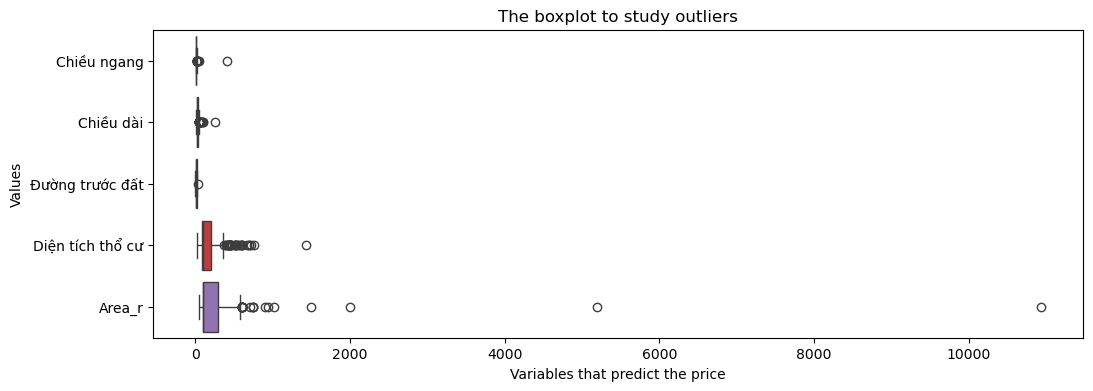

In [206]:
plt.figure(figsize=(12,4))
sns.boxplot(data=dt_tu.drop(columns='Price'), orient='h')
plt.title('The boxplot to study outliers')
plt.xlabel('Variables that predict the price')
plt.ylabel('Values')

Only 3 properties have the Area above 2000 m2, thus can be considered outliers

In [207]:
dt_tu = dt_tu[dt_tu['Area_r']<2000.0]

Text(0, 0.5, 'Values')

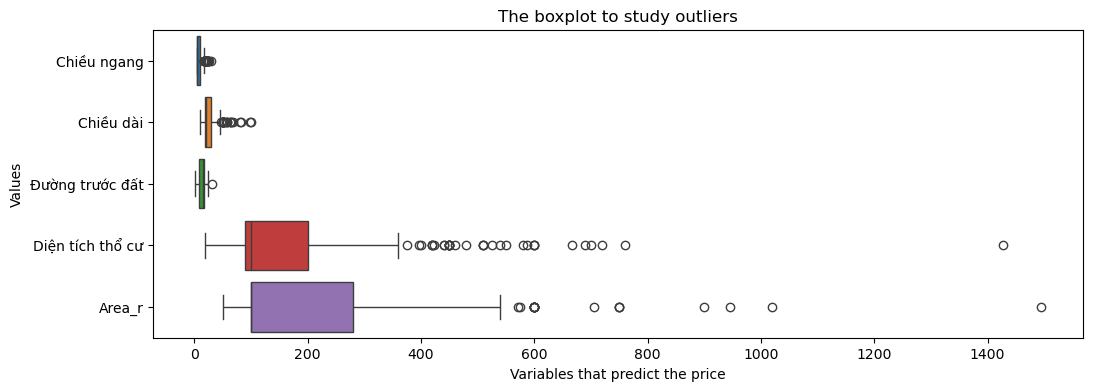

In [208]:
plt.figure(figsize=(12,4))
sns.boxplot(data=dt_tu.drop(columns='Price'), orient='h')
plt.title('The boxplot to study outliers')
plt.xlabel('Variables that predict the price')
plt.ylabel('Values')

<Axes: xlabel='Price'>

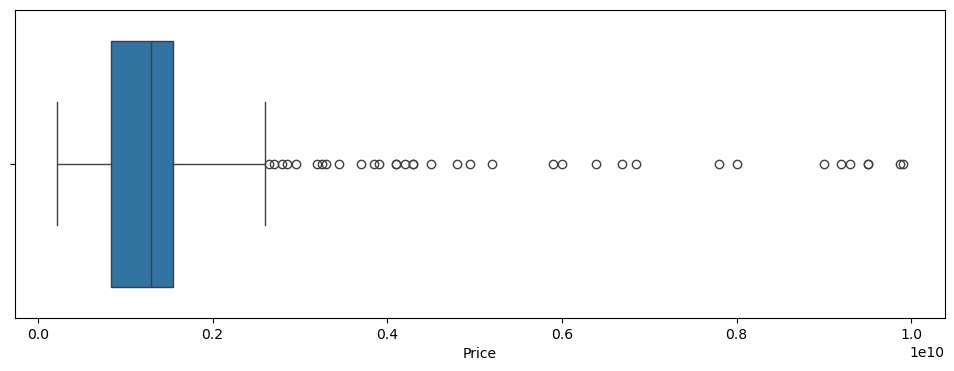

In [209]:
plt.figure(figsize=(12,4))
sns.boxplot(data=dt_tu['Price'], orient='h')

To many outliers but the price of a property maybe skewed by seasonal factors and geometric factors

In [210]:
# Calculate Q1 and Q3
# Q1 = dt_tu['Price'].quantile(0.25)
# Q3 = dt_tu['Price'].quantile(0.75)
# IQR = Q3 - Q1

# # Define outlier bounds
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter out outliers
# dt_tu_filtered = dt_tu.copy()[(dt_tu['Price'] >= lower_bound) & (dt_tu['Price'] <= upper_bound)]
# plt.figure(figsize=(12,4))
# sns.boxplot(data=dt_tu_filtered['Price'], orient='h')

In [211]:
#Check the unique values:
list_obj = dt_tu.drop(columns=[ 'Description']).loc[:, dt_tu.dtypes == object].columns.tolist()
for j in list_obj:
  print(f"Unique values of {j}: {dt_tu[j].unique()}")

Unique values of Address: ['Thuận An' 'Bến Cát' 'Thủ Dầu Một' 'Dầu Tiếng' 'Bàu Bàng' 'Dĩ An'
 'Phú Giáo' 'Bắc Tân Uyên' 'Tân Uyên']
Unique values of Pháp lý: ['Sổ hồng sẵn' 'Đang chờ sổ' 'Hợp đồng mua bán']
Unique values of Tình trạng: ['Đất trống' 'Đất có sẵn nhà' 'Đất có cây ăn trái']
Unique values of Đường: ['Bê tông' 'Nhựa' '10m' 'Đá cấp khối' 'Đất']
Unique values of Đặc điểm nổi bật: ['Mua chính chủ' 'Mua chính chủCó xe đưa đón đi xem đấtGiá rẻ'
 'Mua chính chủCó xe đưa đón đi xem đấtGiá rẻĐất 2 mặt tiền'
 'Mua chính chủĐất 2 mặt tiền' 'Mua chính chủGiá rẻ'
 'Mua chính chủGiá rẻĐất 2 mặt tiền' 'Giá rẻ'
 'Có xe đưa đón đi xem đấtGiá rẻ'
 'Có xe đưa đón đi xem đấtGiá rẻĐất 2 mặt tiền'
 'Mua chính chủCó xe đưa đón đi xem đất' 'Giá rẻĐất 2 mặt tiền'
 'Có xe đưa đón đi xem đất' 'Đất 2 mặt tiền']


In [212]:
# Define the features to one-hot encode
features = ['Mua chính chủ', 'Có xe đưa đón đi xem đất', 'Giá rẻ', 'Đất 2 mặt tiền']

# Create a function to check for the presence of each feature
for feature in features:
    dt_tu[feature] = dt_tu['Đặc điểm nổi bật'].apply(lambda x: 1 if feature in x else 0)
dt_tu = dt_tu[~(dt_tu['Đường']=='10m')]

- The information in Đặc điểm nổi bật may be selected from a drop down menu thus I encode the column 
- The information 10m in Đường does not represent a type of material for the street thus can be considered outlier

In [213]:
dt_tu.info()

<class 'pandas.core.frame.DataFrame'>
Index: 268 entries, 0 to 271
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Price                     268 non-null    float64
 1   Address                   268 non-null    object 
 2   Description               268 non-null    object 
 3   Chiều ngang               268 non-null    float64
 4   Chiều dài                 268 non-null    float64
 5   Đường trước đất           268 non-null    float64
 6   Pháp lý                   268 non-null    object 
 7   Tình trạng                268 non-null    object 
 8   Đường                     268 non-null    object 
 9   Diện tích thổ cư          268 non-null    float64
 10  Đặc điểm nổi bật          268 non-null    object 
 11  Area_r                    268 non-null    float64
 12  Mua chính chủ             268 non-null    int64  
 13  Có xe đưa đón đi xem đất  268 non-null    int64  
 14  Giá rẻ         

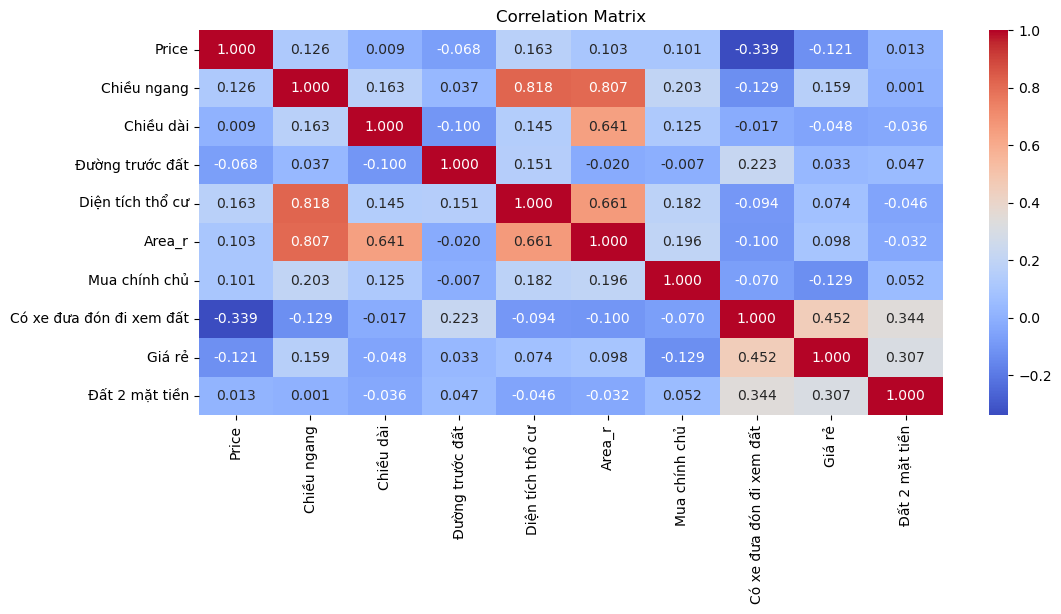

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.heatmap(dt_tu.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt='.3f')
plt.title('Correlation Matrix')
plt.show()

The correlation between the target feature: Price and other features is rather low, which indicate the there are other factors that actually drive the price of a property. The factors may include:
- Economic factors: Economic situation, FDIs, policies that affect the Law on Real Estate, economic events,...
- Geographical factors: nearby locations, center of the province,...
- Population density of the property's location

## Univariate Analysis

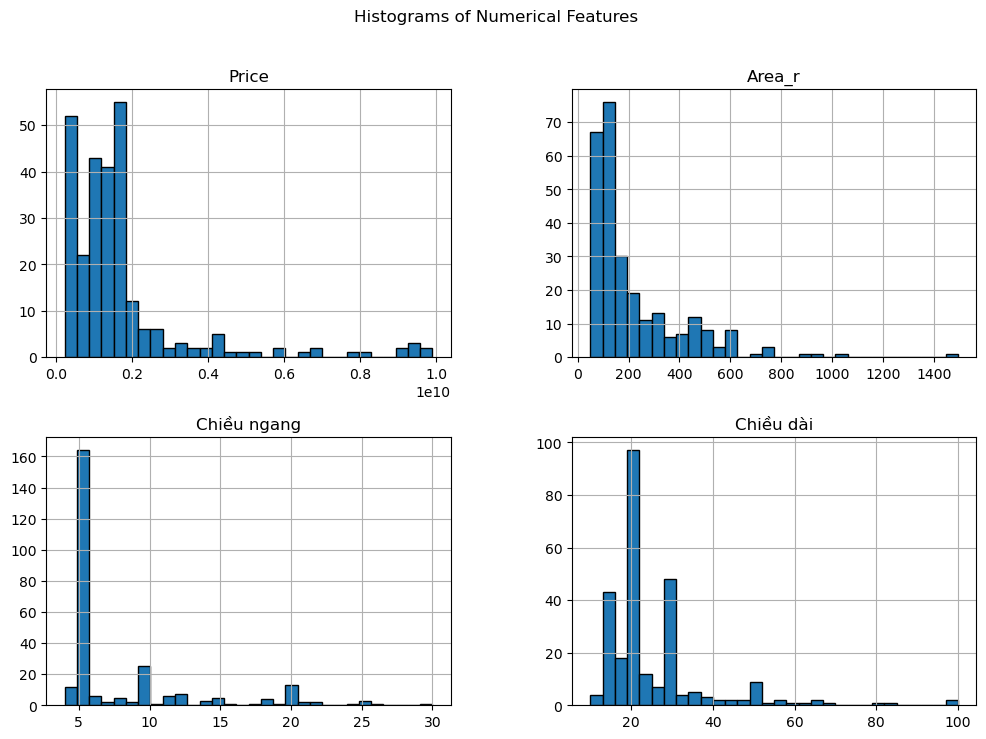

In [215]:
dt_tu[['Price', 'Area_r', 'Chiều ngang', 'Chiều dài']].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

## Bivariate Analysis

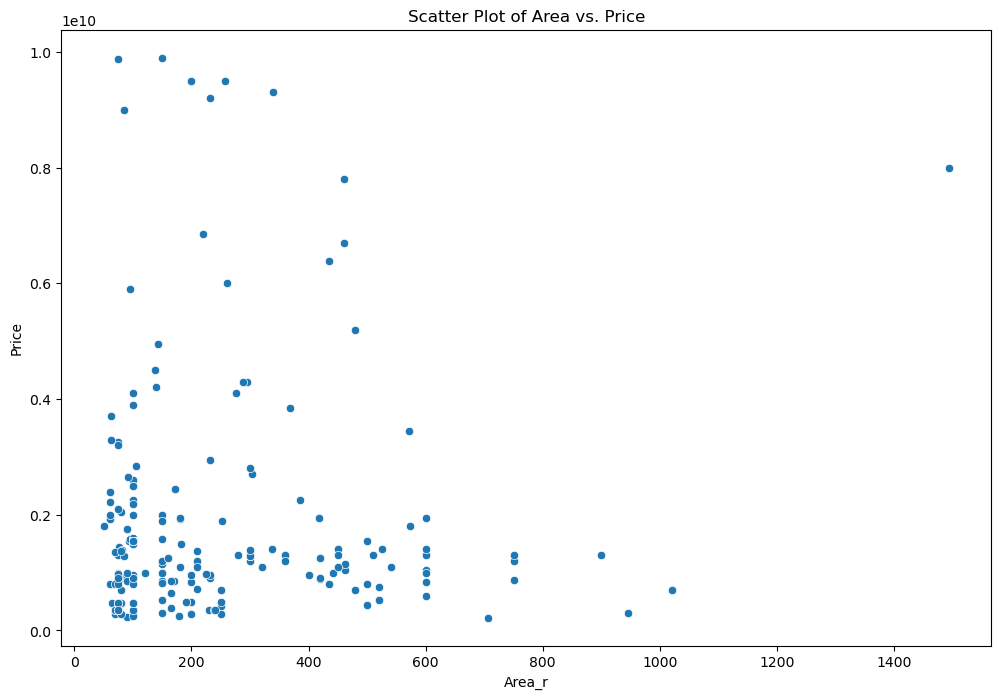

In [216]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Area_r', y='Price', data=dt_tu)
plt.title('Scatter Plot of Area vs. Price')
plt.show()

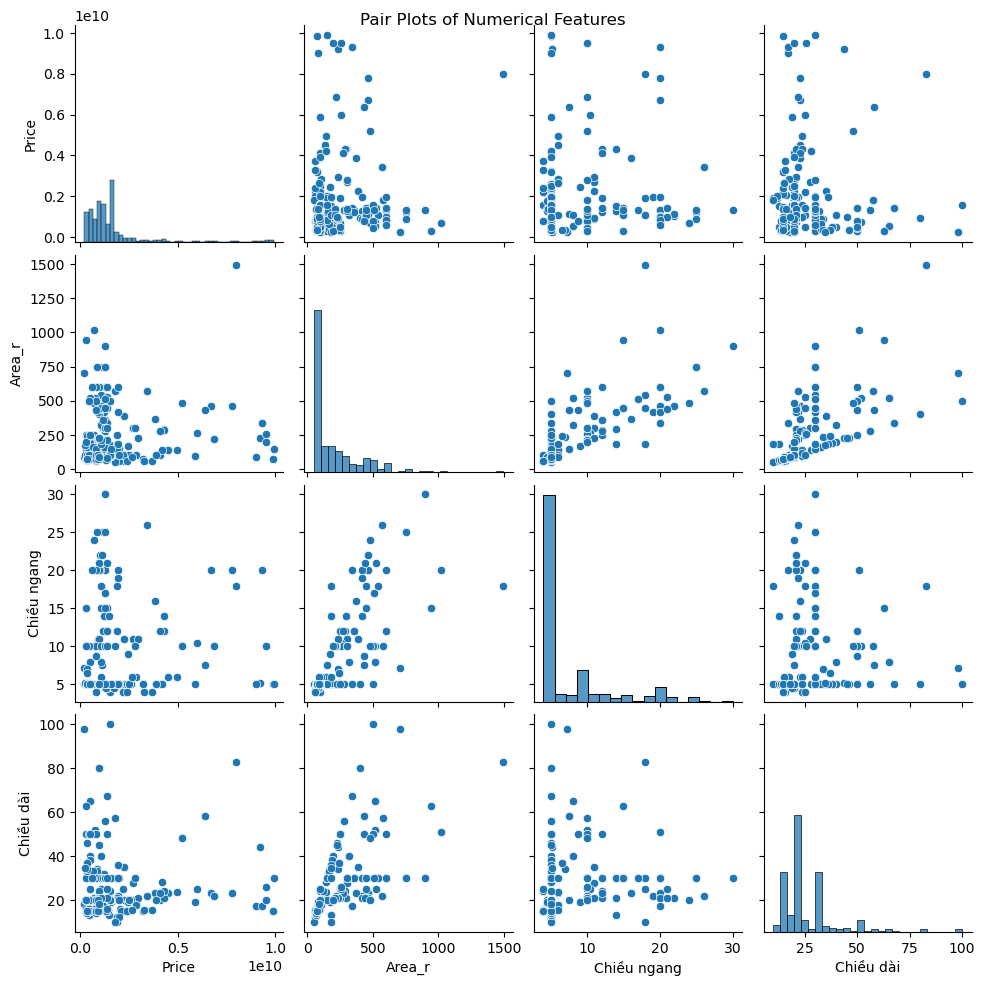

In [217]:
sns.pairplot(dt_tu[['Price', 'Area_r', 'Chiều ngang', 'Chiều dài']])
plt.suptitle('Pair Plots of Numerical Features')
plt.show()

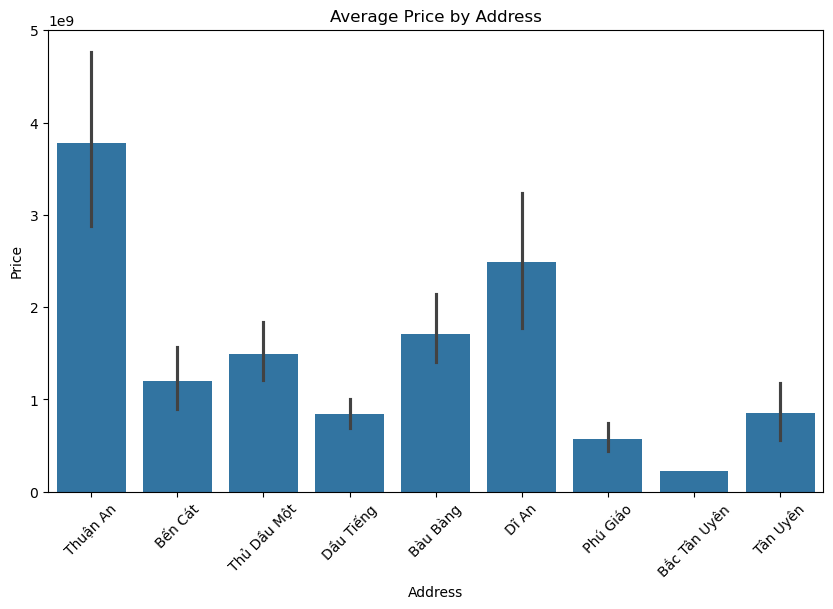

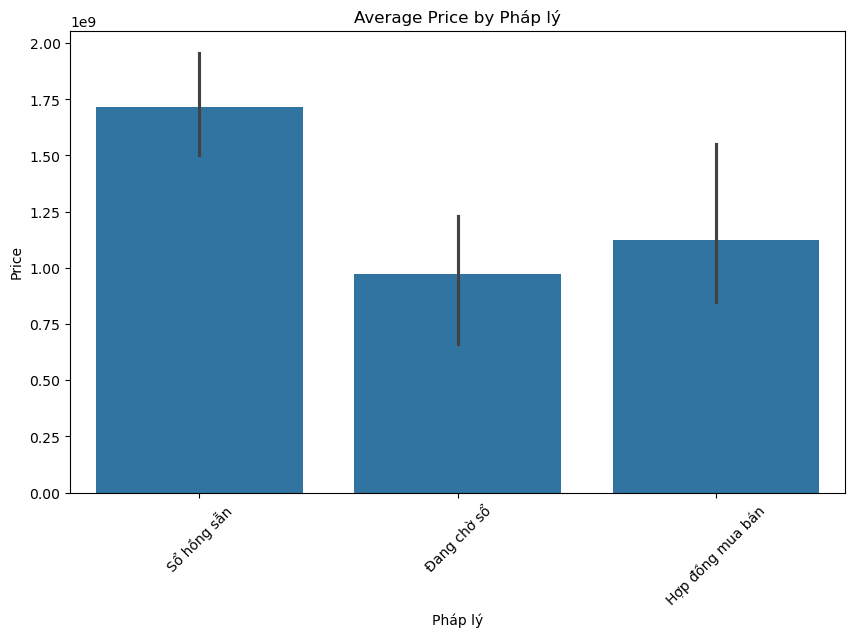

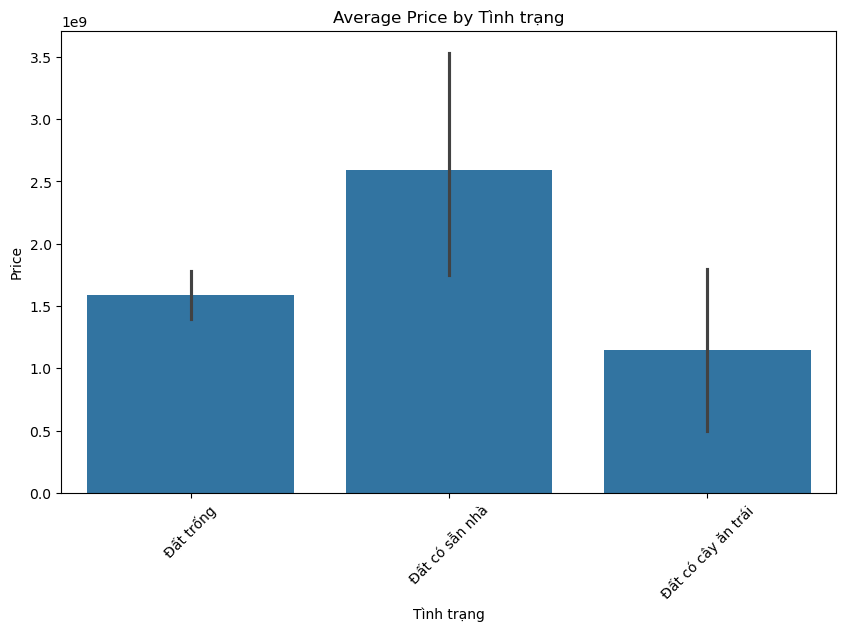

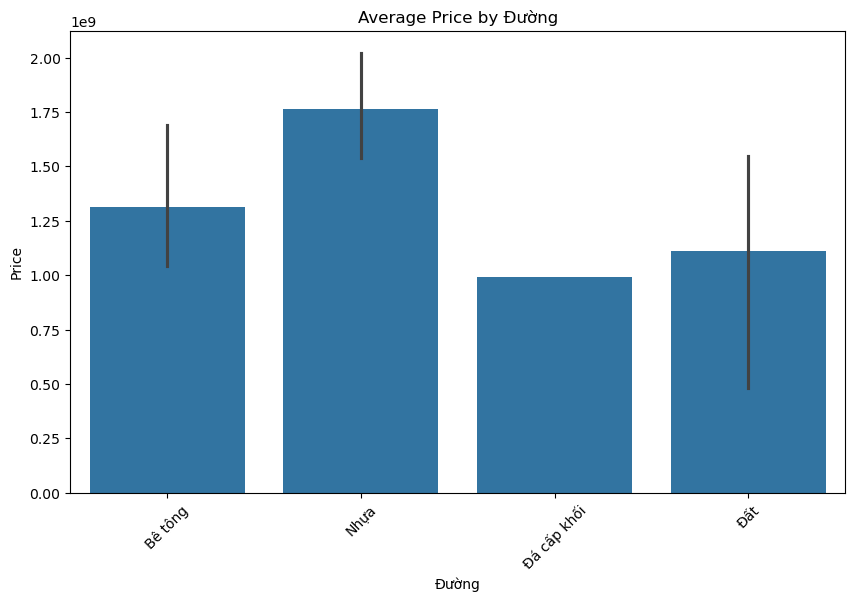

In [218]:
categorical_vars = ['Address', 'Pháp lý', 'Tình trạng', 'Đường']

for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=var, y='Price', data=dt_tu)
    plt.title(f'Average Price by {var}')
    plt.xticks(rotation=45)
    plt.show()

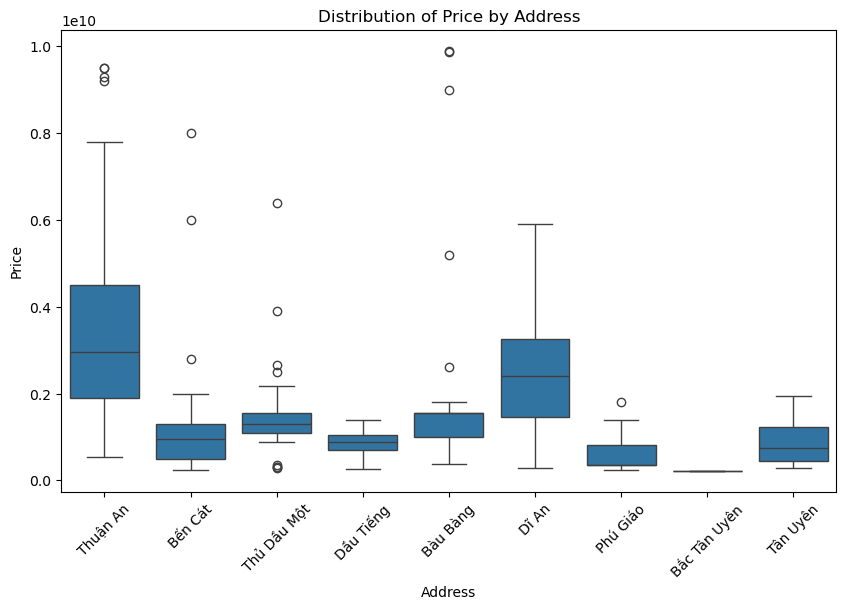

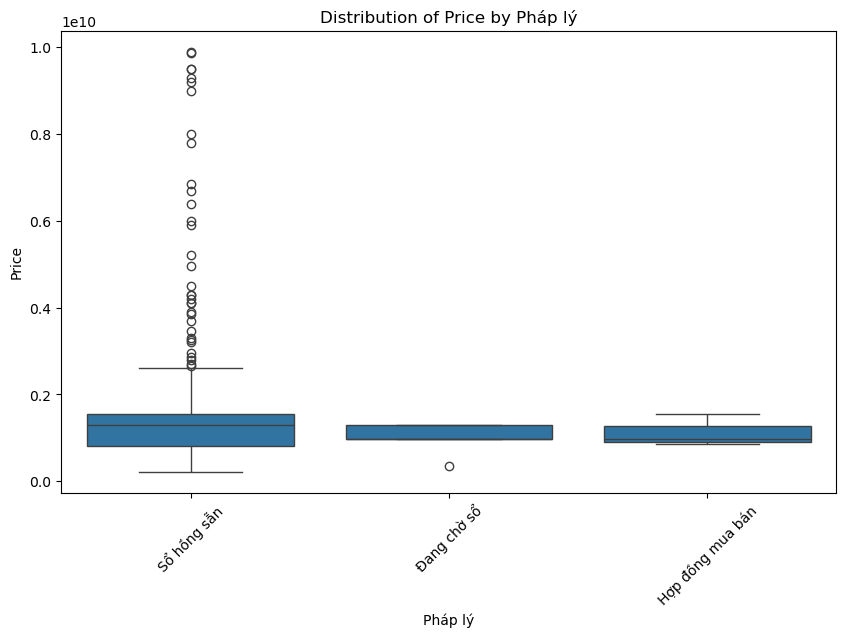

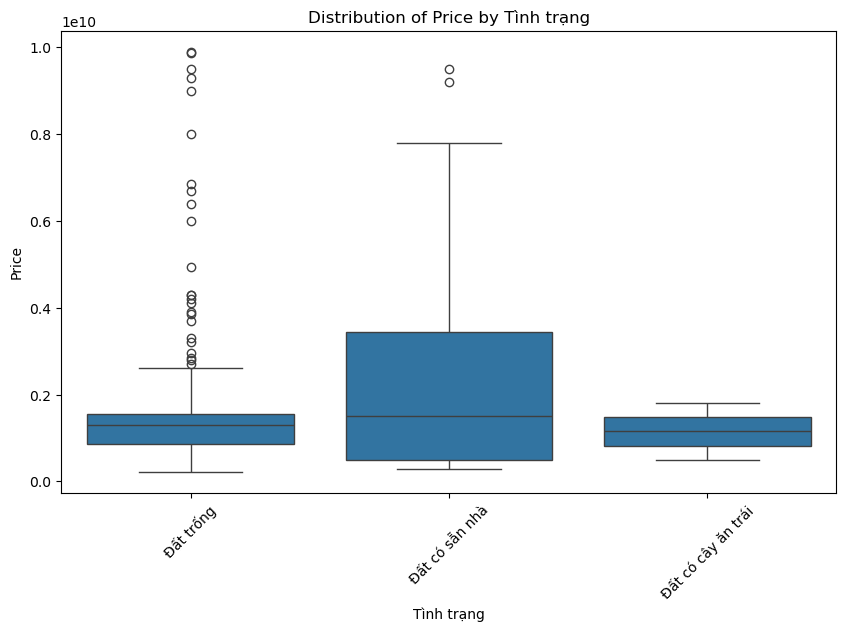

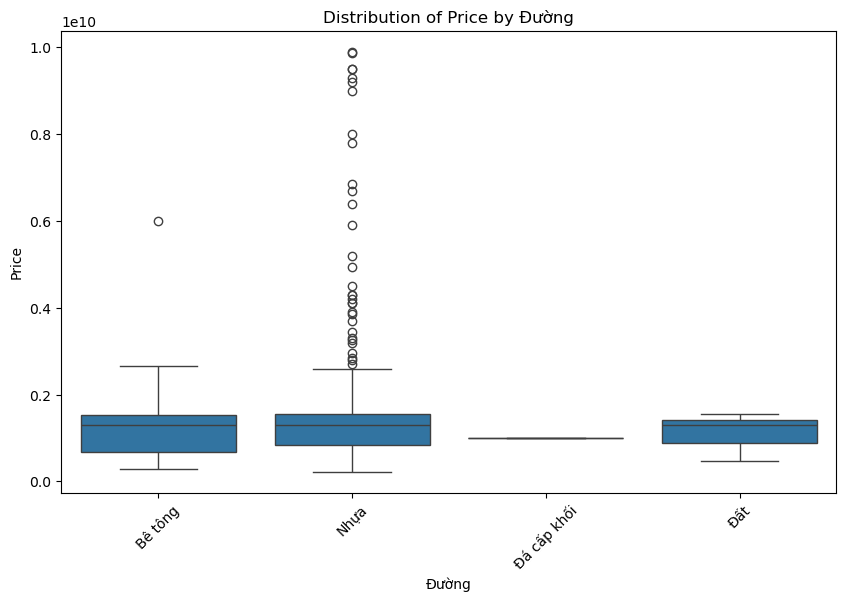

In [219]:
for var in categorical_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=var, y='Price', data=dt_tu)
    plt.title(f'Distribution of Price by {var}')
    plt.xticks(rotation=45)
    plt.show()


Properties with a ready **"Sổ hồng"** (Land Use Rights Certificate), existing buildings, and paved roads tend to have higher prices.

In [220]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.preprocessing import LabelEncoder
X = dt_tu.drop(["Price", "Đặc điểm nổi bật", 'Description'], axis=1)
y = dt_tu["Price"]


# Initialize the LabelEncoder
# le = LabelEncoder()

# Fit and transform the Description column
# X['Description_encoded'] = le.fit_transform(X['Description'])
# X.drop(columns='Description', inplace=True)
X = pd.get_dummies(X, dtype=int)
# Kiểm tra kết quả
X.head()


,Chiều ngang,Chiều dài,Đường trước đất,Diện tích thổ cư,Area_r,Mua chính chủ,Có xe đưa đón đi xem đất,Giá rẻ,Đất 2 mặt tiền,Address_Bàu Bàng,...,Pháp lý_Hợp đồng mua bán,Pháp lý_Sổ hồng sẵn,Pháp lý_Đang chờ sổ,Tình trạng_Đất có cây ăn trái,Tình trạng_Đất có sẵn nhà,Tình trạng_Đất trống,Đường_Bê tông,Đường_Nhựa,Đường_Đá cấp khối,Đường_Đất
0,5.0,20.0,7.0,100.0,100.0,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
1,18.0,30.0,16.0,540.0,540.0,1,1,1,0,0,...,0,1,0,0,0,1,1,0,0,0
2,14.0,30.0,12.0,420.0,420.0,1,1,1,1,0,...,0,1,0,0,0,1,0,1,0,0
3,6.0,23.0,8.0,138.0,138.0,1,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,11.0,27.5,8.0,256.0,302.5,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [221]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành train và test (70% train, 30% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Chia tiếp dữ liệu tạm thời thành validate và test (50% của 30% còn lại)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns)

In [222]:
X.columns

Index(['Chiều ngang', 'Chiều dài', 'Đường trước đất', 'Diện tích thổ cư',
       'Area_r', 'Mua chính chủ', 'Có xe đưa đón đi xem đất', 'Giá rẻ',
       'Đất 2 mặt tiền', 'Address_Bàu Bàng', 'Address_Bắc Tân Uyên',
       'Address_Bến Cát', 'Address_Dĩ An', 'Address_Dầu Tiếng',
       'Address_Phú Giáo', 'Address_Thuận An', 'Address_Thủ Dầu Một',
       'Address_Tân Uyên', 'Pháp lý_Hợp đồng mua bán', 'Pháp lý_Sổ hồng sẵn',
       'Pháp lý_Đang chờ sổ', 'Tình trạng_Đất có cây ăn trái',
       'Tình trạng_Đất có sẵn nhà', 'Tình trạng_Đất trống', 'Đường_Bê tông',
       'Đường_Nhựa', 'Đường_Đá cấp khối', 'Đường_Đất'],
      dtype='object')

In [223]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Support Vector Regressor': SVR(),
    'XGBoost': xgb.XGBRegressor()
}

# Define parameter grids for each model
param_grids = {
    'Linear Regression': {},
    'Random Forest': {
        'n_estimators': [50, 100, 150, 200, 250],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1.0],
        'max_depth': [3, 5, 7]
    },
    'Support Vector Regressor': {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2]
    },
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10]
    }
}


In [224]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through models and their parameter grids
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    
    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled_df, y_train)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Evaluate on validation set
    y_val_pred = best_model.predict(X_val_scaled_df)
    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)
    
    # Store results
    results[name] = {
        'Best Params': best_params,
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name} Results:")
    print(f"Best Params: {metrics['Best Params']}")
    print(f"Mean Squared Error: {metrics['MSE']}")
    print(f"Mean Absolute Error: {metrics['MAE']}")
    print(f"R-squared: {metrics['R2']}")


Training Linear Regression...
Training Random Forest...
Training Gradient Boosting...
Training Support Vector Regressor...
Training XGBoost...

Linear Regression Results:
Best Params: {}
Mean Squared Error: 1.5341280086292838e+18
Mean Absolute Error: 826918132.2550575
R-squared: 0.3460476826486063

Random Forest Results:
Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}
Mean Squared Error: 2.0821086555642908e+18
Mean Absolute Error: 848217153.694237
R-squared: 0.11246012547529982

Gradient Boosting Results:
Best Params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
Mean Squared Error: 2.2745986609524099e+18
Mean Absolute Error: 879403473.999257
R-squared: 0.030407464691788233

Support Vector Regressor Results:
Best Params: {'C': 10, 'epsilon': 0.2, 'kernel': 'linear'}
Mean Squared Error: 2.480753871003744e+18
Mean Absolute Error: 847258150.8886014
R-squared: -0.05747025906321257

XGBoost Results:
Best Params: {'learning_rate': 0.01, 'max_depth': 

The result is really low which indicate the price of a property may be driven by other factors

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5)
ridge_cv.fit(X_train_scaled_df, y_train)


# Lasso Regression
lasso = Lasso()
lasso_params = {'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5)
lasso_cv.fit(X_train_scaled_df, y_train)


# ElasticNet
elastic_net = ElasticNet()
elastic_net_params = {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}
elastic_net_cv = GridSearchCV(elastic_net, elastic_net_params, cv=5)
elastic_net_cv.fit(X_train_scaled_df, y_train)


In [226]:
print("Ridge Best Params:", ridge_cv.best_params_)
print("Ridge Best Score:", ridge_cv.best_score_)
print("Lasso Best Params:", lasso_cv.best_params_)
print("Lasso Best Score:", lasso_cv.best_score_)
print("ElasticNet Best Params:", elastic_net_cv.best_params_)
print("ElasticNet Best Score:", elastic_net_cv.best_score_)

Ridge Best Params: {'alpha': 100.0}
Ridge Best Score: 0.10364578959149624
Lasso Best Params: {'alpha': 1000.0}
Lasso Best Score: -0.08935153702354148
ElasticNet Best Params: {'alpha': 10.0, 'l1_ratio': 0.9}
ElasticNet Best Score: 0.10975160537414416


In [131]:
# Predict using the best Lasso model
best_lasso_model = lasso_cv.best_estimator_
predictions_lasso = best_lasso_model.predict(X)
mse_lasso = mean_squared_error(y, predictions_lasso)
print(f"Lasso - Mean Squared Error: {mse_lasso}")

# Predict using the best Ridge model
best_ridge_model = ridge_cv.best_estimator_
predictions_ridge = best_ridge_model.predict(X)
mse_ridge = mean_squared_error(y, predictions_ridge)
print(f"Ridge - Mean Squared Error: {mse_ridge}")


Lasso - Mean Squared Error: 8.430293761665454e+22
Ridge - Mean Squared Error: 4.674089118143293e+21


In [227]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_estimators=150, max_depth = 10, min_samples_split = 2)

classifier_rf.fit(X_train_scaled_df, y_train.astype(int))
# Extract feature importances
feature_rf_importances = classifier_rf.feature_importances_
# Create a DataFrame with feature names and their importances
imp_rf_df = pd.DataFrame({
    "Features": X.columns,
    "Importance (Random Forest)": feature_rf_importances
})
# Sort by feature importance in descending order
imp_rf_df_sorted = imp_rf_df.sort_values(by="Importance (Random Forest)", ascending=False)
imp_rf_df_sorted

,Features,Importance (Random Forest)
2,Đường trước đất,0.143530
4,Area_r,0.115387
1,Chiều dài,0.114683
3,Diện tích thổ cư,0.107122
9,Address_Bàu Bàng,0.061679
0,Chiều ngang,0.060456
8,Đất 2 mặt tiền,0.052229
11,Address_Bến Cát,0.043109
6,Có xe đưa đón đi xem đất,0.042860
14,Address_Phú Giáo,0.036499


Based on the feature importances derived from the Random Forest model, here are some insights:

### **Top Features Driving the Model:**
1. **Đường trước đất (Front road width) [0.143530]**:
   - This feature has the highest importance, suggesting that the width or type of the road in front of the property is a crucial factor in determining property value. Buyers likely prefer properties with better access and infrastructure, which often correlates with higher prices.

2. **Area_r (Land area) [0.115387]**:
   - The size of the property is naturally a significant determinant of its price. Larger areas usually translate to higher property values, reflecting the importance of space in real estate.

3. **Chiều dài (Length of the property) [0.114683]**:
   - The length of the property also plays a vital role, potentially affecting its utility and appeal for various uses (e.g., residential, agricultural).

4. **Diện tích thổ cư (Residential area) [0.107122]**:
   - The portion of the property designated as residential land is highly important, as it directly impacts the usability of the land for housing, which is often a key factor for buyers.

### **Notable Categorical Features:**
1. **Address_Bàu Bàng [0.061679]**:
   - The specific location of the property, especially in Bàu Bàng, significantly impacts its price, likely due to factors like local infrastructure, development, and market demand in this area.

2. **Đất 2 mặt tiền (Corner lot) [0.052229]**:
   - Properties with two frontages (corner lots) are more valuable, which is reflected in this feature's importance. Corner lots are often more desirable for businesses and residential buyers due to their visibility and accessibility.

3. **Đường_Nhựa (Paved road) [0.022480] & Đường_Bê tông (Concrete road) [0.020755]**:
   - The type of road (whether paved or concrete) influences property value, underscoring the importance of infrastructure and access in real estate pricing.

### **Less Important Features:**
1. **Pháp lý (Legal status) and Tình trạng (Condition) of the property**:
   - Although these features are crucial for buyers, their relatively lower importance scores suggest that they might have less variation across the dataset or that other features, like size and location, overshadow their influence on price.

2. **Specific Addresses with Low Importance (e.g., Bắc Tân Uyên [0.003227])**:
   - Some locations, like Bắc Tân Uyên, have very low importance scores, indicating that properties in these areas may have more uniform pricing, or that location is less of a differentiator here compared to other areas.

3. **Đường_Đá cấp khối (Crushed stone road) [0.000000]**:
   - The lack of importance for this feature suggests that either very few properties have this type of road, or it has no significant impact on property value.

### **General Insights:**
- **Location** and **infrastructure** are key drivers of property prices. Features like road type and specific locations within the broader area significantly impact the value.
- **Property size and dimensions** are crucial. Both the overall area and specific dimensions (length and width) play a significant role in pricing.
- **Legal status and condition** of the property, while important, may not be as strong differentiators in this dataset, possibly due to less variation in these features.

These insights can be valuable for real estate professionals and buyers alike in understanding what factors most influence property prices in this market.